In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def print_error_lineplot(df, distribution, ax=None):
    df['gc_error'] = abs(df['real_entropy'] - df['gcmi_entropy'])
    df['knn_error'] = abs(df['real_entropy'] - df['npeet_entropy'])

    n_variables_order = list(df['n_variables'].unique())
    n_n_variables = len(n_variables_order)

    ax = sns.lineplot(data=df, x='n_samples', y='gc_error', hue='n_variables', hue_order=n_variables_order, palette=sns.color_palette('Blues', n_n_variables+3)[3:], ax=ax)
    sns.lineplot(data=df, x='n_samples', y='knn_error', hue='n_variables', hue_order=n_variables_order, palette=sns.color_palette('Reds', n_n_variables+3)[3:], ax=ax)

    ax.set_xscale('log')
    ax.set_ylabel('Error')
    ax.set_xlabel('Number of samples')

    gc_handles = [
        Line2D([0], [0], color=sns.color_palette('Blues', n_n_variables+3)[i+3], lw=2, label=n_variables)
        for i,n_variables in enumerate(n_variables_order)
    ]
    ksg_handles = [
        Line2D([0], [0], color=sns.color_palette('Reds', n_n_variables+3)[i+3], lw=2, label=n_variables)
        for i,n_variables in enumerate(n_variables_order)
    ]

    ax.add_artist(ax.legend(handles=gc_handles, title='GC', loc='upper left', bbox_to_anchor=(1.02, 1.0)))
    ax.legend(handles=ksg_handles, title='KSG', loc='upper left', bbox_to_anchor=(1.02, 0.55))
    ax.grid(True)

    ax.set_title(distribution)

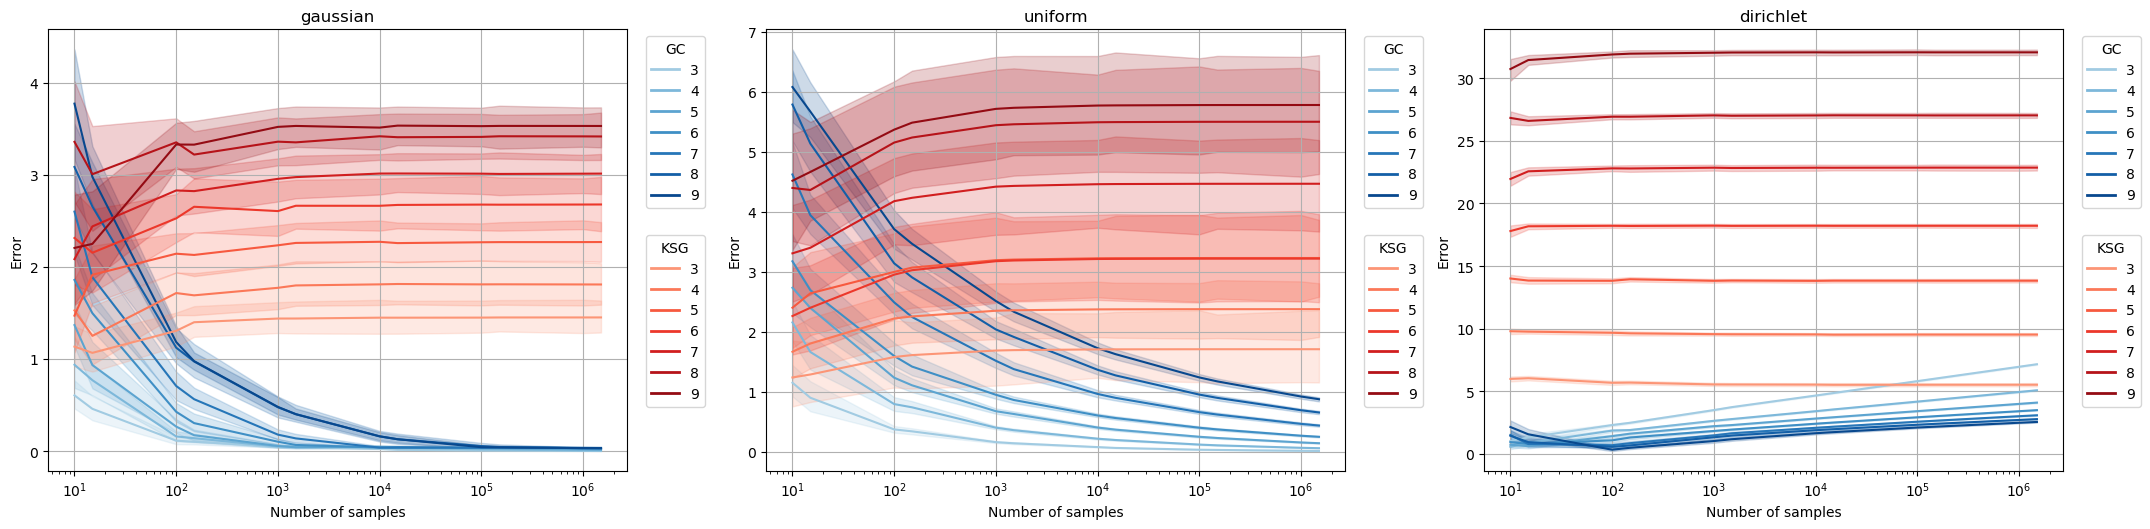

In [3]:
distributions = ['gaussian', 'uniform', 'dirichlet']
n_distributions = len(distributions)
fig, axes = plt.subplots(1, n_distributions, figsize=(n_distributions*8, 6))

for ax, distribution in zip(axes, distributions):
    df = pd.read_csv(f'../benchmarking/results/estimators/distribution-{distribution}_repeat-20.tsv', sep='\t')
    print_error_lineplot(df, distribution, ax=ax)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()